# Challenge Deep Learning

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images de champignons.
Le jeu de données proposé comprend 3 classes balancées

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Vous devez prendre en compte la spécificité des données (peu d'exemples, images de tailles différentes,...) pour construire vos jeux d'apprentissage et de test.

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur une base que nous conservons, pour voir si les résultats que vous proposez sont reproductibles. 

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous **expliquerez votre démarche**, **justifierez vos choix**, **commenterez vos expérimentations et vos résultats**.

La notation sera construite de la manière suivante : 
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. 

Le notebook sera déposé sur la plateforme moodle du cours.

In [57]:
import os
import zipfile
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


# Test GPU

In [58]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU détecté : {gpus}")
else:
    print("Aucun GPU détecté. Vérifiez vos installations.")
    exit()

Num GPUs Available:  1
GPU détecté : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Chargement des données

Pour entraîner notre modèle, nous avons décidé de collecter davantage d’images des trois catégories champignons afin de disposer d’un jeu de données plus étendu. Nous conservons le jeu de données d’origine pour tester notre modèle et utilisons notre nouveau corpus de plus de 13k+ images, trié manuellement, pour l’entraînement.

In [59]:
def Data():
    base_dir = "mushrooms"
    test_dir = "test_mushrooms"
    
    train_dir = os.path.join(base_dir)
    test_dir = os.path.join(test_dir)
    
    train_classes = os.listdir(train_dir)
    test_classes = os.listdir(test_dir)

    
    print("Classes d'entraînement:", train_classes)
    print("Classes de test:", test_classes)
    

    if set(train_classes) != set(test_classes):
        print("Attention : Les classes dans les ensembles d'entraînement et de test ne correspondent pas !")
    

    train_data = []
    for label in train_classes:
        image_files = os.listdir(os.path.join(train_dir, label))
        train_data.extend([(label, os.path.join(train_dir, label, f)) for f in image_files])
    
    test_data = []
    for label in test_classes:
        image_files = os.listdir(os.path.join(test_dir, label))
        test_data.extend([(label, os.path.join(test_dir, label, f)) for f in image_files])
    

    print("Nombre total d'images d'entraînement:", len(train_data))
    print("Nombre total d'images de test:", len(test_data))
    print("Nombre d'images par classe dans l'ensemble d'entraînement:",
          {label: len(os.listdir(os.path.join(train_dir, label))) for label in train_classes if label != "test"})
    print("Nombre d'images par classe dans l'ensemble de test:",
          {label: len(os.listdir(os.path.join(test_dir, label))) for label in test_classes})
    
    return train_data, test_data

In [60]:
train_data, test_data = Data()

Classes d'entraînement: ['amanita', 'crimini', 'oyster']
Classes de test: ['amanita', 'crimini', 'oyster']
Nombre total d'images d'entraînement: 13123
Nombre total d'images de test: 1470
Nombre d'images par classe dans l'ensemble d'entraînement: {'amanita': 4179, 'crimini': 4121, 'oyster': 4823}
Nombre d'images par classe dans l'ensemble de test: {'amanita': 520, 'crimini': 416, 'oyster': 534}


## Exemple de données d'entrainement

In [61]:
import matplotlib.pyplot as plt
image_samples = np.random.randint(0,high=len(train_data)-1, size=8)

fig = plt.figure(figsize=(16,6))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(2,4,i+1)
    axs.set_title(train_data[img_idx][0])
    image = Image.open(train_data[img_idx][1])
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Exemples de données")
plt.tight_layout()

Error in callback <function flush_figures at 0x7fb065094e50> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

## Chargement du model à spécialisé pour connaitre les dimention de l'input

## Generation de variation d'image

In [51]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,                            # Normalisation des pixels (0-1)
    rotation_range=20,                          # Rotation aléatoire des images
    width_shift_range=0.2,                      # Décalage horizontal
    height_shift_range=0.2,                     # Décalage vertical
    shear_range=0.2,                            # Transformation en cisaillement
    zoom_range=0.2,                             # Zoom
    horizontal_flip=True,                       # Flip horizontal
    fill_mode='nearest'                         # Mode de remplissage
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)


train_dir = "mushrooms" 
test_dir  = "test_mushrooms"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,  
    class_mode='categorical'
)

Found 13123 images belonging to 3 classes.
Found 1470 images belonging to 3 classes.


## Ajustement des poits des classes en fonctions des performances précédente

In [52]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {'amanita': 0.75, 'crimini': 1.5, 'oyster': 1.0}


## Callback

In [53]:
from tensorflow.keras.callbacks import Callback

class SaveEveryNEpochs(Callback):
    def __init__(self, save_freq, model, save_path):
        super(SaveEveryNEpochs, self).__init__()
        self.save_freq = save_freq
        self.model_to_save = model
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            filepath = self.save_path.format(epoch=epoch + 1)
            self.model_to_save.save(filepath)
            print(f"Model saved at {filepath}")


## Load (or Create) and Train the MobileNetV2-based Model

In [55]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

EPOCHS = 50

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = train_generator.num_classes

try :
    print("Chargement du modèle existant...")
    model = load_model("mushroom_classifier_model.h5")
    print("Modèle chargé.")
except :
    print("Pas de modèle trouvé.\nCréation d'un nouveau modèle...")

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    for layer in base_model.layers[-20:]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)


#### CallBack ####

save_every_n_epochs = SaveEveryNEpochs(
    save_freq=1, 
    model=model, 
    save_path="model/model_epoch_{epoch:02d}.h5"
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)


model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), #Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


### Train ###
 
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    class_weight=class_weights_numeric,
    callbacks=[save_every_n_epochs, early_stopping, checkpoint]
)

Chargement du modèle existant...
Pas de modèle trouvé.
Création d'un nouveau modèle...
Epoch 1/50
411/411 [==============================] - ETA: 0s - loss: 1.1152 - accuracy: 0.4479

/home/xerneas02/miniconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved at model/model_epoch_01.h5
411/411 [==============================] - 186s 426ms/step - loss: 1.1152 - accuracy: 0.4479 - val_loss: 0.7411 - val_accuracy: 0.6279
Epoch 2/50
411/411 [==============================] - 184s 447ms/step - loss: 0.8041 - accuracy: 0.6348 - val_loss: 0.5675 - val_accuracy: 0.7585
Epoch 3/50
411/411 [==============================] - 179s 434ms/step - loss: 0.6749 - accuracy: 0.7316 - val_loss: 0.4640 - val_accuracy: 0.8286
Epoch 4/50
411/411 [==============================] - 164s 399ms/step - loss: 0.6204 - accuracy: 0.7632 - val_loss: 0.4302 - val_accuracy: 0.8435
Epoch 5/50
411/411 [==============================] - 160s 389ms/step - loss: 0.5635 - accuracy: 0.7878 - val_loss: 0.3635 - val_accuracy: 0.8571
Epoch 6/50
411/411 [==============================] - 158s 384ms/step - loss: 0.5205 - accuracy: 0.8011 - val_loss: 0.3902 - val_accuracy: 0.8544
Epoch 7/50
411/411 [==============================] - 159s 386ms/step - loss: 0.5055 - accuracy:

## Save

In [19]:
# After training your model
model.save('mushroom_classifier_model.h5')

## Load

In [ ]:
model = load_model('best_model.h5')
input_shape = model.input_shape
_, img_height, img_width, _ = input_shape

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 128, 128, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None, 'name': 'input_layer_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'scale': 0.00392156862745098, 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'rescaling_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 128, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['rescaling_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'batch_normalization_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['activation_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'separable_conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['activation_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['separable_conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_8', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'separable_conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['activation_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 256]}, 'name': 'batch_normalization_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['separable_conv2d_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 256, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['activation_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_3', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 32, 32, 256], [None, 32, 32, 256]]}, 'name': 'add_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['max_pooling2d_3', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_9', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'separable_conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['activation_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 512]}, 'name': 'batch_normalization_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 512], 'dtype': 'float32', 'keras_history': ['separable_conv2d_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_10', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 512, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 512]}, 'name': 'separable_conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 512], 'dtype': 'float32', 'keras_history': ['activation_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 512]}, 'name': 'batch_normalization_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 512], 'dtype': 'float32', 'keras_history': ['separable_conv2d_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 512, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 256]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 256], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 16, 16, 512], [None, 16, 16, 512]]}, 'name': 'add_4', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['max_pooling2d_4', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_11', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'separable_conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['activation_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 728]}, 'name': 'batch_normalization_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 728], 'dtype': 'float32', 'keras_history': ['separable_conv2d_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 728], 'dtype': 'float32', 'keras_history': ['batch_normalization_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 728, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 728]}, 'name': 'separable_conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 728], 'dtype': 'float32', 'keras_history': ['activation_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 728]}, 'name': 'batch_normalization_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 728], 'dtype': 'float32', 'keras_history': ['separable_conv2d_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'pool_size': [3, 3], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'name': 'max_pooling2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 728], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 728, 'kernel_size': [1, 1], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 512]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 512], 'dtype': 'float32', 'keras_history': ['add_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 8, 728], [None, 8, 8, 728]]}, 'name': 'add_5', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 728], 'dtype': 'float32', 'keras_history': ['max_pooling2d_5', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 728], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'SeparableConv2D', 'config': {'name': 'separable_conv2d_13', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'depth_multiplier': 1, 'filters': 1024, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'activation': 'linear', 'use_bias': True, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'pointwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'depthwise_regularizer': None, 'pointwise_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'depthwise_constraint': None, 'pointwise_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 728]}, 'name': 'separable_conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 728], 'dtype': 'float32', 'keras_history': ['add_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 1024]}, 'name': 'batch_normalization_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 1024], 'dtype': 'float32', 'keras_history': ['separable_conv2d_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'activation_15', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'activation': 'relu'}, 'registered_name': None, 'name': 'activation_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 1024], 'dtype': 'float32', 'keras_history': ['batch_normalization_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'name': 'global_average_pooling2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 1024], 'dtype': 'float32', 'keras_history': ['activation_15', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'rate': 0.25, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'name': 'dropout_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1024], 'dtype': 'float32', 'keras_history': ['global_average_pooling2d_1', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}, 'name': 'dense_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 1024], 'dtype': 'float32', 'keras_history': ['dropout_1', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_1', 0, 0]], 'output_layers': [['dense_1', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0003000000142492354, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'CategoricalCrossentropy', 'config': {'name': 'categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'label_smoothing': 0.0, 'axis': -1}, 'registered_name': None}, 'loss_weights': None, 'metrics': [{'module': 'keras.metrics', 'class_name': 'CategoricalAccuracy', 'config': {'name': 'acc', 'dtype': 'float32'}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}

## Test

Found 1470 images belonging to 3 classes.
 4/46 [=>............................] - ETA: 13s - loss: 0.1831 - accuracy: 0.9531

/home/xerneas02/.local/lib/python3.9/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


46/46 [==============================] - 21s 420ms/step - loss: 0.2681 - accuracy: 0.9102
Précision sur l'ensemble de test: 0.91


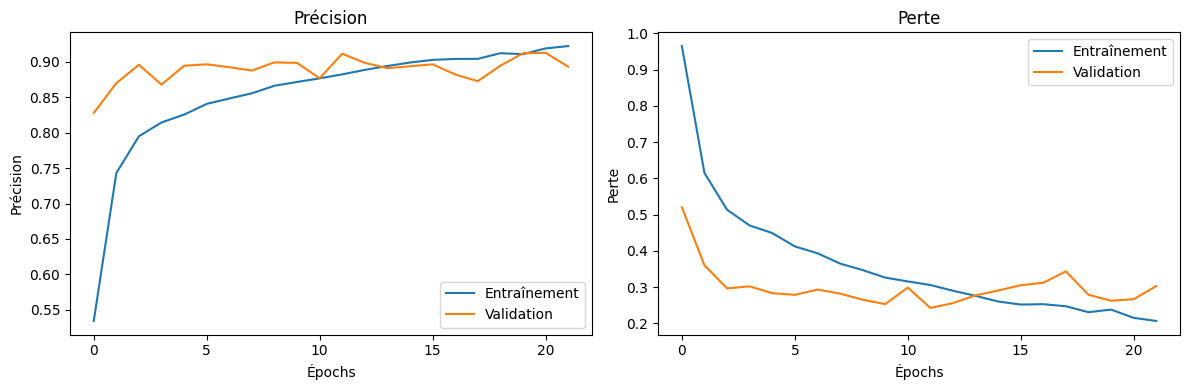

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Évaluation sur les données de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Précision sur l'ensemble de test: {test_acc:.2f}")

# Visualisation des courbes de précision et de perte
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.tight_layout()
plt.show()

46/46 [==============================] - 20s 409ms/step


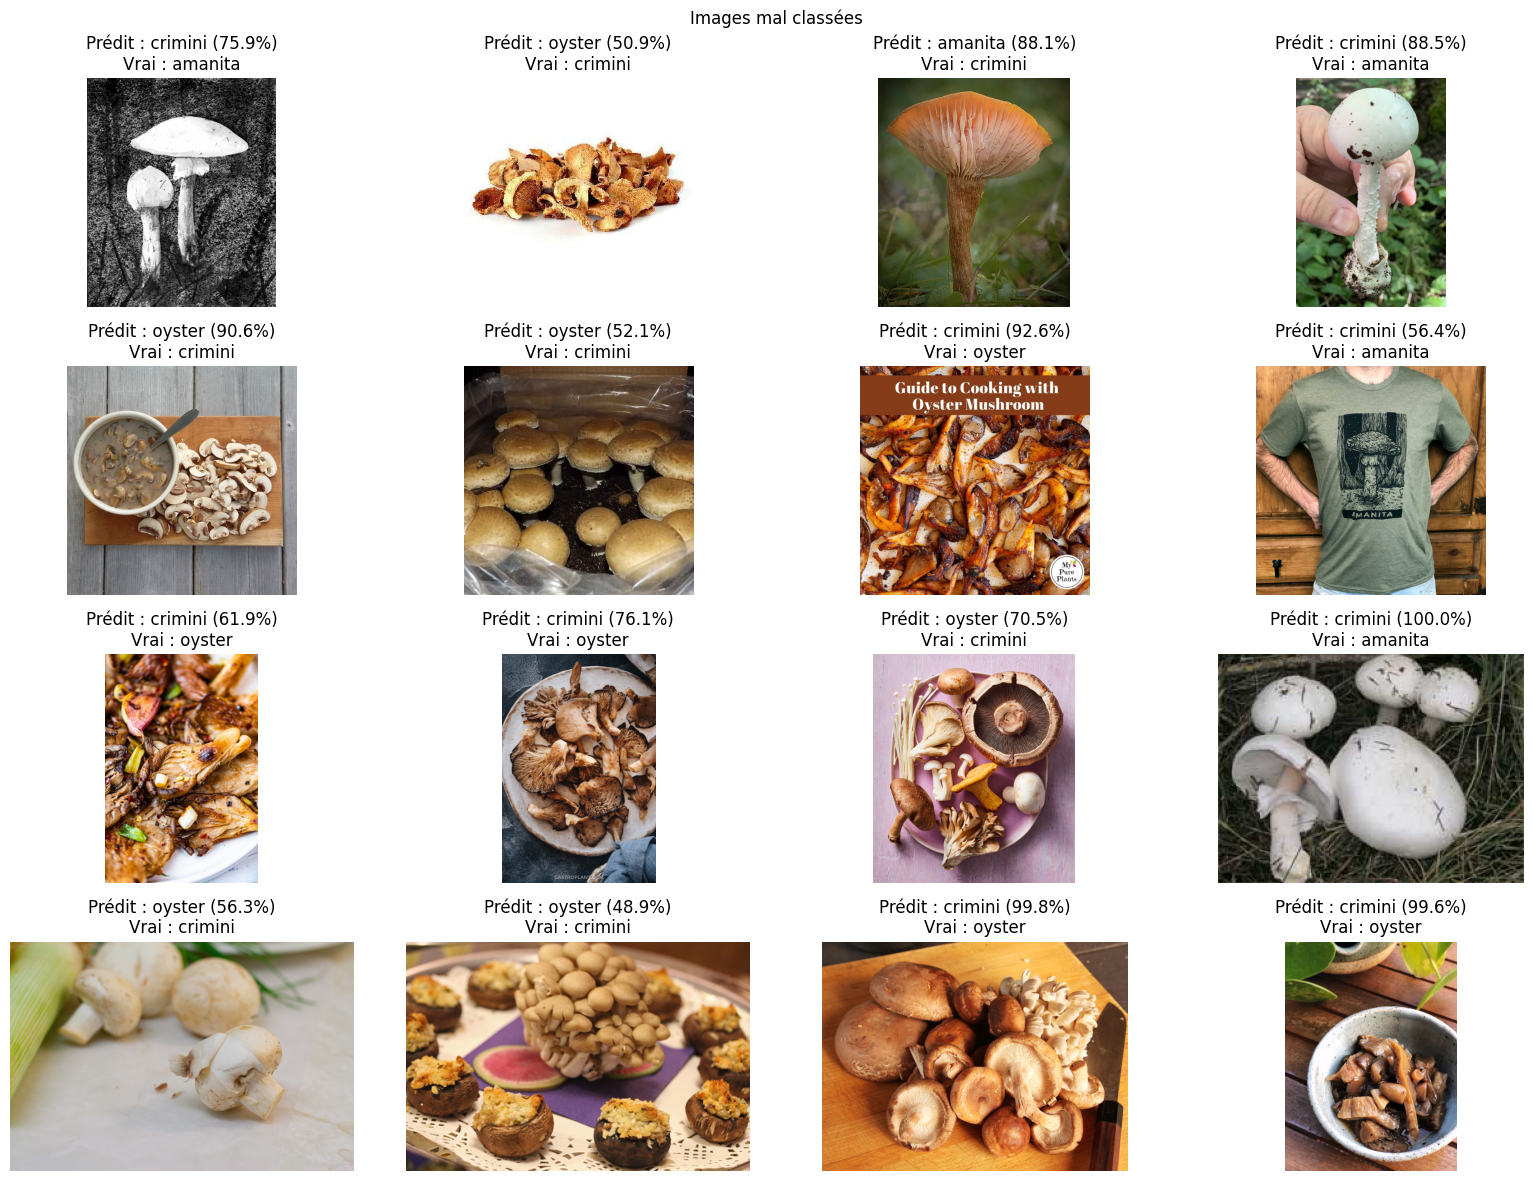

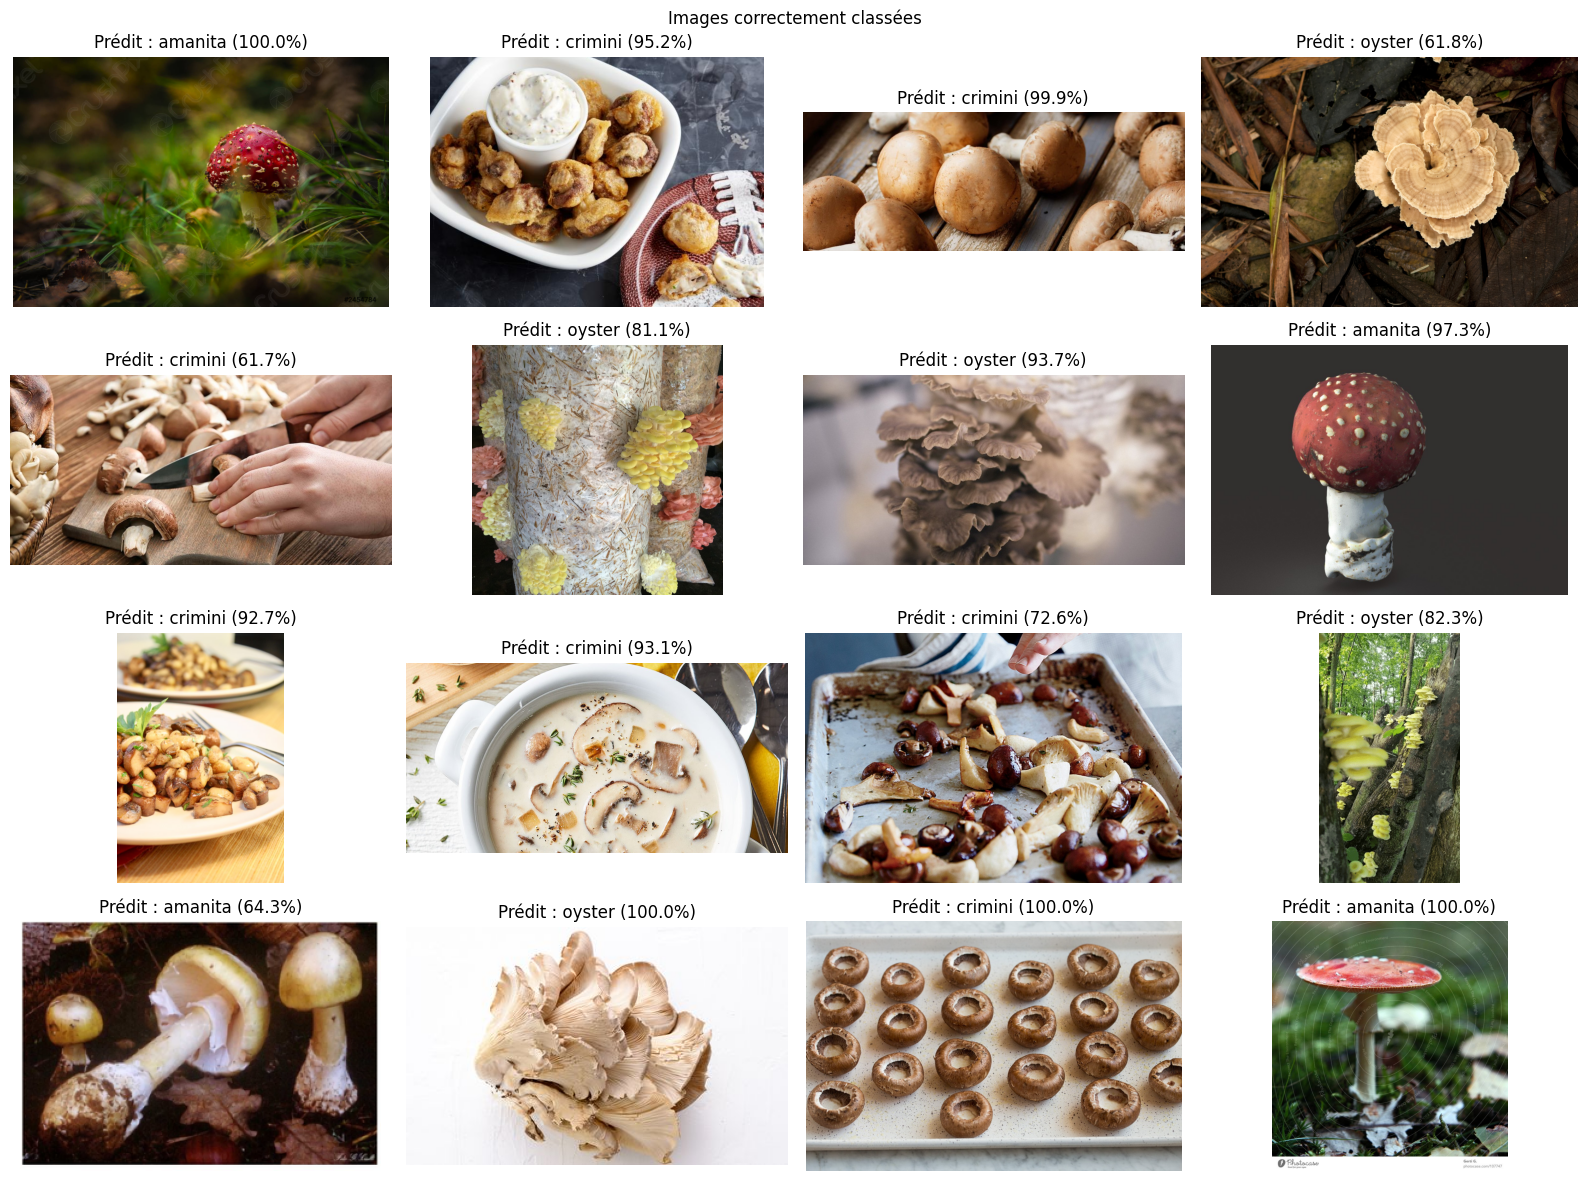

Taux de réussite global : 91.02%
Taux de réussite par catégorie :
  - amanita : 93.08%
  - crimini : 88.94%
  - oyster : 90.64%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Obtenir les noms des classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Prédictions du modèle sur les données de test
Y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred_confidence = np.max(Y_pred, axis=1) 

# Étiquettes vraies
y_true = test_generator.classes

# Trouver les indices des prédictions correctes et incorrectes
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# Calcul du taux de réussite global
accuracy = len(correct) / len(y_true) * 100

# Calcul du taux de réussite par catégorie
category_accuracy = {}
for class_name in class_names:
    class_idx = class_indices[class_name]
    total_in_class = np.sum(y_true == class_idx)
    correct_in_class = np.sum((y_true == class_idx) & (y_pred == class_idx))
    if total_in_class > 0:
        category_accuracy[class_name] = correct_in_class / total_in_class * 100
    else:
        category_accuracy[class_name] = None

# Fonction pour afficher les images avec le taux de confiance
def display_images(indices, title):
    num_samples = 16
    if len(indices) < num_samples:
        num_samples = len(indices)
    image_samples = np.random.choice(indices, size=num_samples, replace=False)
    
    fig = plt.figure(figsize=(16, 12))
    for i, idx in enumerate(image_samples):
        axs = fig.add_subplot(4, 4, i+1)
        image_path = test_generator.filepaths[idx]
        image = Image.open(image_path)
        plt.imshow(image)
        
        confidence = y_pred_confidence[idx] * 100  # Convertir en pourcentage
        
        if title == "Images mal classées":
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)\nVrai : {class_names[y_true[idx]]}")
        else:
            axs.set_title(f"Prédit : {class_names[y_pred[idx]]} ({confidence:.1f}%)")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Afficher des images où le modèle s'est trompé avec le taux de confiance
display_images(incorrect, "Images mal classées")

# Afficher des images où le modèle a correctement prédit avec le taux de confiance
display_images(correct, "Images correctement classées")

# Affichage des taux de réussite
print(f"Taux de réussite global : {accuracy:.2f}%")
print("Taux de réussite par catégorie :")
for class_name, acc in category_accuracy.items():
    if acc is not None:
        print(f"  - {class_name} : {acc:.2f}%")
    else:
        print(f"  - {class_name} : Pas d'images dans cette catégorie")
